In [ ]:
import os
from pathlib import Path
import h5py
import warnings
import pandas as pd

from tqdm import tqdm

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

from matplotlib.ticker import FormatStrFormatter, FixedLocator, ScalarFormatter, MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

import seaborn as sns


In [2]:
folder_path2 = 'D:\\GWDG\\LSM_Challenge\\Dataset_2024_Mar\\Clustering_metrics_correlation'

file_name1 = 'CondGANOpenMeterprivat.parquet'; syngan = pd.read_parquet(os.path.join(folder_path2, file_name1))
#file_name2 = 'ddpm_om_privat.parquet'; synddpm = pd.read_parquet(os.path.join(folder_path2, file_name2))
file_name3 = 'privat_test_origData.parquet'; original = pd.read_parquet(os.path.join(folder_path2, file_name3))

In [3]:
folder_path2 = 'D:\GWDG\LSM_Challenge\Dataset_2024_Mar\Privat'

file_name4 = 'ddpm_om_privat_retransformed.csv'; synddpm = pd.read_csv(os.path.join(folder_path2, file_name4), index_col=0)

##### Preparation of df from Nikita's csv. Datetime wrong formatting and "/" in name of columns

In [4]:
synddpm.index = pd.to_datetime(synddpm.index)
synddpm.columns = synddpm.columns.str.lstrip("/")
synddpm.to_parquet('ddpm_om_privat_for_2019_2021.parquet')

##### Check df

In [5]:
#synddpm

In [6]:
#original

### Preparation for plotting

In [7]:
ori_gan_diff = syngan.subtract(original)
ori_ddpm_diff = synddpm.subtract(original)

In [ ]:
#ori_ddpm_diff

In [9]:
def calculate_mean_by_weekday_hour_minute(list_of_dfs):
    concatenated_df = pd.concat(list_of_dfs, axis=1)

    # Extract weekday, hour, and minute from the index
    concatenated_df['weekday'] = concatenated_df.index.strftime('%A')
    concatenated_df['hour'] = concatenated_df.index.hour
    concatenated_df['minute'] = concatenated_df.index.minute

    # Group by weekday, hour, and minute and calculate the mean
    mean_by_weekday = concatenated_df.groupby(['weekday', 'hour', 'minute']).mean()

    # Construct the name of the output DataFrame with the suffix _whm
    output_df_name = "_".join([df.columns[0] for df in list_of_dfs]) + "_whm"

    # Assign the constructed name to the output DataFrame
    mean_by_weekday.name = output_df_name

    return mean_by_weekday

In [10]:
list_of_dfs = [ori_gan_diff]
ori_gan_diff_whm = calculate_mean_by_weekday_hour_minute(list_of_dfs)
ori_gan_diff_whm = ori_gan_diff_whm.iloc[:,1:]

list_of_dfs = [ori_ddpm_diff]
ori_ddpm_diff_whm = calculate_mean_by_weekday_hour_minute(list_of_dfs)
ori_ddpm_diff_whm = ori_ddpm_diff_whm.iloc[:,1:]


In [11]:

def calculate_mean_and_ci(data_frame, columns_to_ignore=['weekday', 'hour', 'minute'], confidence_level=0.95):
    # Select only the data columns
    data_frame = data_frame.reset_index()
    data_columns = data_frame.drop(columns_to_ignore, axis=1)

    # Calculate the mean over all data columns for each row, ignoring NaNs
    mean_values = data_columns.mean(axis=1, skipna=True)

    # Calculate the confidence interval for each row, ignoring NaNs
    confidence_interval = data_columns.apply(lambda row: stats.t.interval(
        confidence_level, len(row.dropna())-1, loc=row.mean(skipna=True), scale=stats.sem(row, nan_policy='omit')), axis=1)

    # Create a new DataFrame with mean and confidence interval columns
    result_df = pd.DataFrame({
        'weekday': data_frame['weekday'],
        'hour': data_frame['hour'],
        'minute': data_frame['minute'],
        'Mean': mean_values,
        'Lower CI': confidence_interval.apply(lambda x: x[0]),
        'Upper CI': confidence_interval.apply(lambda x: x[1])
    })
    
    return result_df

# Example usage:
# result_df = calculate_mean_and_ci(input_df)

In [12]:
ori_gan_diff_whm_means = calculate_mean_and_ci(ori_gan_diff_whm)

ori_ddpm_diff_whm_means = calculate_mean_and_ci(ori_ddpm_diff_whm)

In [13]:
# Define a custom function to calculate hour + (60/minute)
def calculate_new_column(row):
    if row['minute'] != 0:
        return row['hour'] + (row['minute']/60)
    else:
        return row['hour']  # Handle division by zero by returning just 'hour'

In [14]:
ori_gan_diff_whm_means['datetime'] = ori_gan_diff_whm_means.apply(calculate_new_column, axis=1)

ori_ddpm_diff_whm_means['datetime'] = ori_ddpm_diff_whm_means.apply(calculate_new_column, axis=1)

In [15]:
# Create a dictionary for English to German weekday translation
translation_dict = {
    'Monday': 'Montag',
    'Tuesday': 'Dienstag',
    'Wednesday': 'Mittwoch',
    'Thursday': 'Donnerstag',
    'Friday': 'Freitag',
    'Saturday': 'Samstag',
    'Sunday': 'Sonntag'
}

ori_gan_diff_whm_means['weekday'] = ori_gan_diff_whm_means['weekday'].map(translation_dict)

ori_ddpm_diff_whm_means['weekday'] = ori_ddpm_diff_whm_means['weekday'].map(translation_dict)


### Prep Original-Data

In [16]:
# def calculate_mean_by_weekday_hour_minute(list_of_dfs):
#     concatenated_df = pd.concat(list_of_dfs, axis=1)

#     # Extract weekday, hour, and minute from the index
#     concatenated_df['weekday'] = concatenated_df.index.strftime('%A')
#     concatenated_df['hour'] = concatenated_df.index.hour
#     concatenated_df['minute'] = concatenated_df.index.minute

#     # Group by weekday, hour, and minute and calculate the mean
#     mean_by_weekday = concatenated_df.groupby(['weekday', 'hour', 'minute']).mean()

#     # Construct the name of the output DataFrame with the suffix _whm
#     output_df_name = "_".join([df.columns[0] for df in list_of_dfs]) + "_whm"

#     # Assign the constructed name to the output DataFrame
#     mean_by_weekday.name = output_df_name

#     return mean_by_weekday

In [17]:
original2 = original.copy()
list_of_dfs = [original2]
original_whm = calculate_mean_by_weekday_hour_minute(list_of_dfs)
original_whm = original_whm.iloc[:,1:]

original_whm_means_ci = calculate_mean_and_ci(original_whm)
original_whm_means_ci['datetime'] = original_whm_means_ci.apply(calculate_new_column, axis=1)
original_whm_means_ci['weekday'] = original_whm_means_ci['weekday'].map(translation_dict)

### Prep SYN-Data

In [18]:
syngan2 = syngan.copy()
list_of_dfs = [syngan2]
syngan_whm = calculate_mean_by_weekday_hour_minute(list_of_dfs)
syngan_whm = syngan_whm.iloc[:,1:]

syngan_whm_means_ci = calculate_mean_and_ci(syngan_whm)
syngan_whm_means_ci['datetime'] = syngan_whm_means_ci.apply(calculate_new_column, axis=1)
syngan_whm_means_ci['weekday'] = syngan_whm_means_ci['weekday'].map(translation_dict)

In [19]:
synddpm2 = synddpm.copy()
list_of_dfs =[synddpm2]
synddpm_whm = calculate_mean_by_weekday_hour_minute(list_of_dfs)
synddpm_whm = synddpm_whm.iloc[:,1:]

synddpm_whm_means_ci = calculate_mean_and_ci(synddpm_whm)
synddpm_whm_means_ci['datetime'] = synddpm_whm_means_ci.apply(calculate_new_column, axis=1)
synddpm_whm_means_ci['weekday'] = synddpm_whm_means_ci['weekday'].map(translation_dict)

In [20]:
#syngan_whm_means_ci

In [21]:
#syngan_whm_means_ci

### Optimize df for 24h - Plotting

In [22]:
def convert_data_types(df):
    df[['Mean', 'Lower CI', 'Upper CI','datetime']] = df[['Mean', 'Lower CI', 'Upper CI','datetime']].apply(pd.to_numeric)
    df[['hour', 'minute']] = df[['hour', 'minute']].astype(int)
    df['weekday'] = pd.Categorical(df['weekday'], ordered=True)
    return df

In [23]:
def copy_to_fullday(df):
    # Iterate over unique weekdays
    dfs = []
    for weekday in df['weekday'].unique():
        # Filter DataFrame for the current weekday
        df_day = df[df['weekday'] == weekday].copy()
        
        # Copy the first row and modify the datetime value
        first_row = df_day.iloc[0].copy()
        first_row['datetime'] = 24.0
        first_row['hour'] = 24
        
        # Concatenate the modified row to the end of the DataFrame
        df_day = pd.concat([df_day, pd.DataFrame(first_row).transpose()], ignore_index=True)
        
        # Append the modified DataFrame to the list
        dfs.append(df_day)

    # Concatenate all DataFrames together
    result_df = pd.concat(dfs, ignore_index=True)

    # Sort the result DataFrame by weekday and datetime
    result_df = result_df.sort_values(by=['weekday', 'datetime']).reset_index(drop=True)
    
    return result_df

In [24]:
original_whm_means_ci2 = copy_to_fullday(original_whm_means_ci)
ori_gan_diff_whm_means2  = copy_to_fullday(ori_gan_diff_whm_means)
syngan_whm_means_ci2  = copy_to_fullday(syngan_whm_means_ci)

original_whm_means_ci2 = convert_data_types(original_whm_means_ci2)
ori_gan_diff_whm_means2 = convert_data_types(ori_gan_diff_whm_means2)
syngan_whm_means_ci2 = convert_data_types(syngan_whm_means_ci2)


synddpm_whm_means_ci2 = copy_to_fullday(synddpm_whm_means_ci)
ori_ddpm_diff_whm_means2 = copy_to_fullday(ori_ddpm_diff_whm_means)

synddpm_whm_means_ci2 = convert_data_types(synddpm_whm_means_ci2)
ori_ddpm_diff_whm_means2 = convert_data_types(ori_ddpm_diff_whm_means2)

In [25]:
# #FOR kW

# original_whm_means_ci3 = original_whm_means_ci2.copy()
# original_whm_means_ci3[['Mean', 'Lower CI', 'Upper CI']] /= 1000

# ori_gan_diff_whm_means3 = ori_gan_diff_whm_means2.copy()
# ori_gan_diff_whm_means3[['Mean', 'Lower CI', 'Upper CI']] /= 1000

# syngan_whm_means_ci3 = syngan_whm_means_ci2.copy()
# syngan_whm_means_ci3[['Mean', 'Lower CI', 'Upper CI']] /= 1000

In [ ]:
#syngan_whm_means_ci2

In [ ]:
#synddpm_whm_means_ci2

# PLOTTING

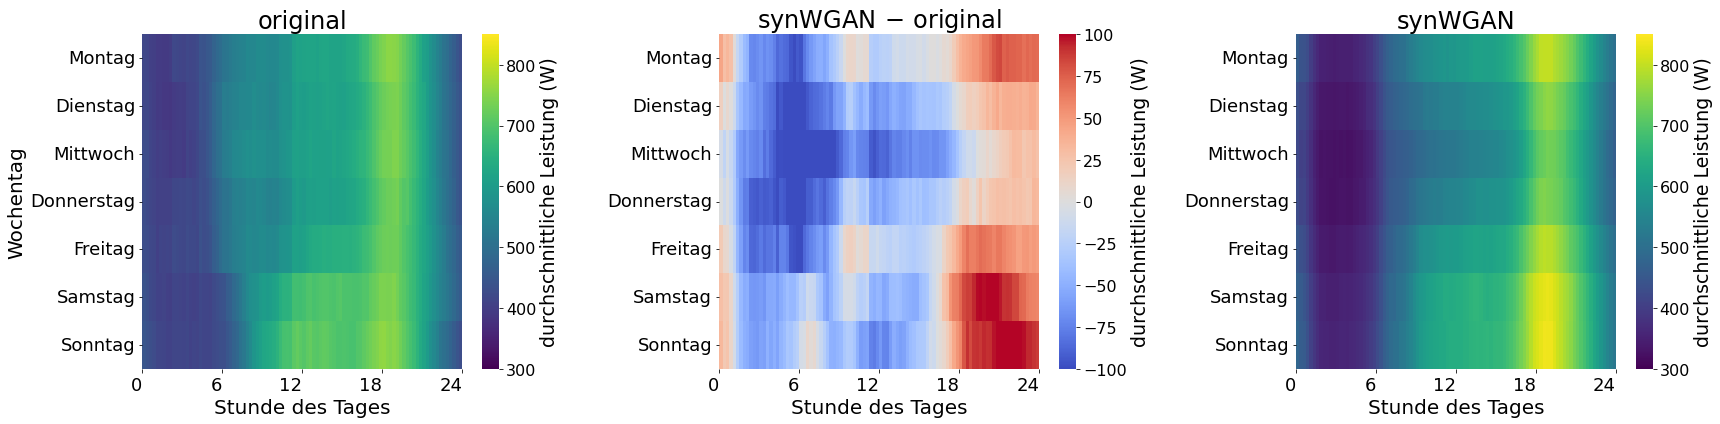

In [28]:
# Define custom order for weekdays
custom_weekday_order = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']

# Function to format x-axis ticks with 0 decimals
def format_ticks_no_decimals(value, _):
    return f'{int(value)}'

# Function to plot the heatmap for a specific dataframe
def plot_heatmap(ax, df, title, cmap, vmin, vmax, ylabelcolor='black'):
    # Convert the "weekday" column to a categorical type with custom ordering
    df['weekday'] = pd.Categorical(df['weekday'], categories=custom_weekday_order, ordered=True)

    # Pivot the dataframe to create a matrix for the heatmap
    heatmap_data = df.pivot_table(index='weekday', columns='datetime', values='Mean', aggfunc='mean')

    # Plot the heatmap
    sns.heatmap(ax=ax, data=heatmap_data, cmap=cmap, annot=False, fmt=".0f", linewidths=0, vmin=vmin, vmax=vmax , 
                cbar_kws={'label': 'Leistung in Watt'})

    ax.set_title(title, fontsize=24)
    ax.set_xlabel('Stunde des Tages', fontsize=20)
    ax.set_ylabel('Wochentag', fontsize=20, color=ylabelcolor)
    ax.set_xlim(0,24)
 
    # Style changes
    ax.tick_params(axis='both', labelsize=18)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Horizontal y-axis labels
  
    # x_tick_positions = np.arange(0, 97, 24)
    # x_tick_labels = heatmap_data['datetime'][x_tick_positions].astype(int)  # Convert to integers
  
    #ax.set_xticks(x_tick_positions, x_tick_labels, rotation=0, fontsize=16)
    x_tick_positions = np.arange(0, 98, 24)
    x_tick_labels = df['datetime'][x_tick_positions].astype(int)
    ax.set_xticks(x_tick_positions)
    ax.set_xticklabels(x_tick_labels, rotation=0, ha='right')
    # Use FuncFormatter to format x-axis labels without decimal points
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: int(x/4)))

    #ax.grid(True, color=sns.color_palette()[3], alpha=1)  # Adjust alpha for transparency
    ax.grid(True, color='none', alpha=1)
    
    cbar = ax.collections[0].colorbar
    cbar.ax.set_ylabel('durchschnittliche Leistung (W)', fontsize=19)
    cbar.ax.tick_params(labelsize=16)


# Create a 1x3 grid for subplots
fig, axs = plt.subplots(1, 3, figsize=(24, 6))


#Manual Parameters for subplots
colormaps = ['viridis', 'coolwarm', 'viridis']
vmins = [300, -100, 300]  # Min values for each subplot
vmaxs = [850, 100, 850]  # Max values for each subplot
ylabel_colors = ['black', 'white', 'blue']


plot_heatmap(axs[0], original_whm_means_ci2, 'original', colormaps[0], vmins[0], vmaxs[0], ylabelcolor=ylabel_colors[0])
plot_heatmap(axs[1], ori_gan_diff_whm_means2, 'synWGAN $\! - \!$ original', colormaps[1], vmins[1], vmaxs[1], ylabelcolor=ylabel_colors[1])
plot_heatmap(axs[2], syngan_whm_means_ci, 'synWGAN', colormaps[2], vmins[2], vmaxs[2], ylabelcolor=ylabel_colors[1])

# for ax in axs:
#     ax.xaxis.set_major_formatter(FuncFormatter(format_ticks_no_decimals))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

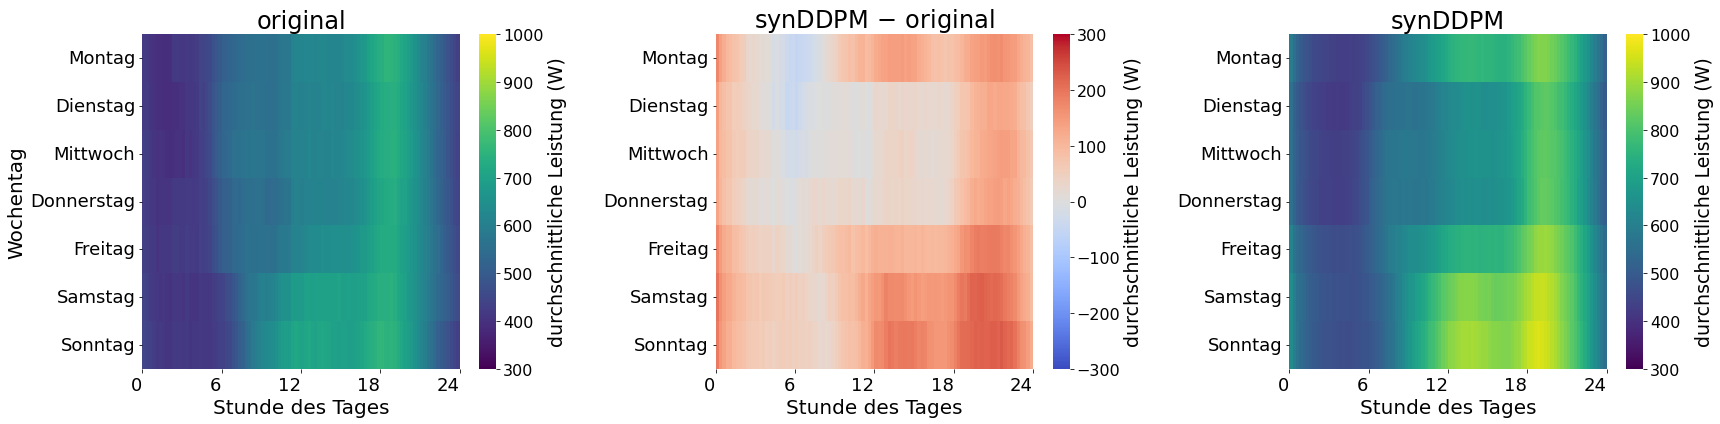

In [29]:
# Define custom order for weekdays
custom_weekday_order = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']

# Function to format x-axis ticks with 0 decimals
def format_ticks_no_decimals(value, _):
    return f'{int(value)}'

# Function to plot the heatmap for a specific dataframe
def plot_heatmap(ax, df, title, cmap, vmin, vmax, ylabelcolor='black'):
    # Convert the "weekday" column to a categorical type with custom ordering
    df['weekday'] = pd.Categorical(df['weekday'], categories=custom_weekday_order, ordered=True)

    # Pivot the dataframe to create a matrix for the heatmap
    heatmap_data = df.pivot_table(index='weekday', columns='datetime', values='Mean', aggfunc='mean')

    # Plot the heatmap
    sns.heatmap(ax=ax, data=heatmap_data, cmap=cmap, annot=False, fmt=".0f", linewidths=0, vmin=vmin, vmax=vmax , 
                cbar_kws={'label': 'Leistung in Watt'})

    ax.set_title(title, fontsize=24)
    ax.set_xlabel('Stunde des Tages', fontsize=20)
    ax.set_ylabel('Wochentag', fontsize=20, color=ylabelcolor)
    ax.set_xlim(0,24)
 
    # Style changes
    ax.tick_params(axis='both', labelsize=18)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Horizontal y-axis labels
  
    # x_tick_positions = np.arange(0, 97, 24)
    # x_tick_labels = heatmap_data['datetime'][x_tick_positions].astype(int)  # Convert to integers
  
    #ax.set_xticks(x_tick_positions, x_tick_labels, rotation=0, fontsize=16)
    x_tick_positions = np.arange(0, 98, 24)
    x_tick_labels = df['datetime'][x_tick_positions].astype(int)
    ax.set_xticks(x_tick_positions)
    ax.set_xticklabels(x_tick_labels, rotation=0, ha='right')
    # Use FuncFormatter to format x-axis labels without decimal points
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: int(x/4)))

    #ax.grid(True, color=sns.color_palette()[3], alpha=1)  # Adjust alpha for transparency
    ax.grid(True, color='none', alpha=1)
    
    cbar = ax.collections[0].colorbar
    cbar.ax.set_ylabel('durchschnittliche Leistung (W)', fontsize=19)
    cbar.ax.tick_params(labelsize=16)


# Create a 1x3 grid for subplots
fig, axs = plt.subplots(1, 3, figsize=(24, 6))


#Manual Parameters for subplots
colormaps = ['viridis', 'coolwarm', 'viridis']
vmins = [300, -700, 300, -0, -400, -300]  # Min values for each subplot
vmaxs = [1000, 700, 850, 160, 400, 300]  # Max values for each subplot
ylabel_colors = ['black', 'white', 'blue']


plot_heatmap(axs[0], original_whm_means_ci2, 'original', colormaps[0], vmins[0], vmaxs[0], ylabelcolor=ylabel_colors[0])
plot_heatmap(axs[1], ori_ddpm_diff_whm_means2, 'synDDPM $\! - \!$ original', colormaps[1], vmins[5], vmaxs[5], ylabelcolor=ylabel_colors[1])
plot_heatmap(axs[2], synddpm_whm_means_ci2, 'synDDPM', colormaps[2], vmins[0], vmaxs[0], ylabelcolor=ylabel_colors[1])

# for ax in axs:
#     ax.xaxis.set_major_formatter(FuncFormatter(format_ticks_no_decimals))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [168]:
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator

# Function to plot the data for a specific dataframe
def plot_dataframe(ax, df, linestyle_dict, title, fontsize=20, ylim=None):
    # Convert the "weekday" column to a categorical type with custom ordering
    df['weekday'] = pd.Categorical(df['weekday'], categories=custom_weekday_order, ordered=True)

    # Plot using Seaborn's lineplot
    ax.set_title(title, fontsize=fontsize+8, fontweight='bold')
    ax.set_xlabel('Tageszeit', fontsize=fontsize+6)
    ax.set_ylabel('Leistung in Watt', fontsize=fontsize+6)
    ax.set_xlim(0, 24)
    
    
    # Set major ticks on x-axis every 6 hours
    ax.xaxis.set_major_locator(plt.MultipleLocator(6))

    # Adjusting axis linewidth and color
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['top'].set_color('black')  # Set color to black
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['right'].set_color('black')  # Set color to black
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['bottom'].set_color('black')  # Set color to black
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')  # Set color to black

    # Set y-axis limits if provided
    if ylim is not None:
        ax.set_ylim(ylim)
        
    # Iterate through unique weekdays and plot each line separately
    for weekday in custom_weekday_order:
        subset_data = df[df['weekday'] == weekday]
        
        # Define color based on weekday
        if weekday in ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag']:
            line_color = '#4a8081'
            fill_color = '#4a8081'  # Match line color for weekdays
        else:
            line_color = '#dd9b4b'
            fill_color = '#dd9b4b'  # Match line color for weekends
        
        sns.lineplot(ax=ax, data=subset_data, x='datetime', y='Mean', label=weekday,
                    linestyle=linestyle_dict[weekday], linewidth=2.5, color=line_color)

        # Plot the shaded area for the confidence interval with selective color
        ax.fill_between(subset_data['datetime'], subset_data['Lower CI'], subset_data['Upper CI'],
                        color=fill_color, alpha=0.2)

        # Set fontsize for axis labels and tick labels
        ax.tick_params(axis='both', labelsize=fontsize-2)
        ax.legend(fontsize=fontsize-9)
        # Style changes
        ax.grid(True, color='grey', alpha=0.5)  # Adjust alpha for transparency


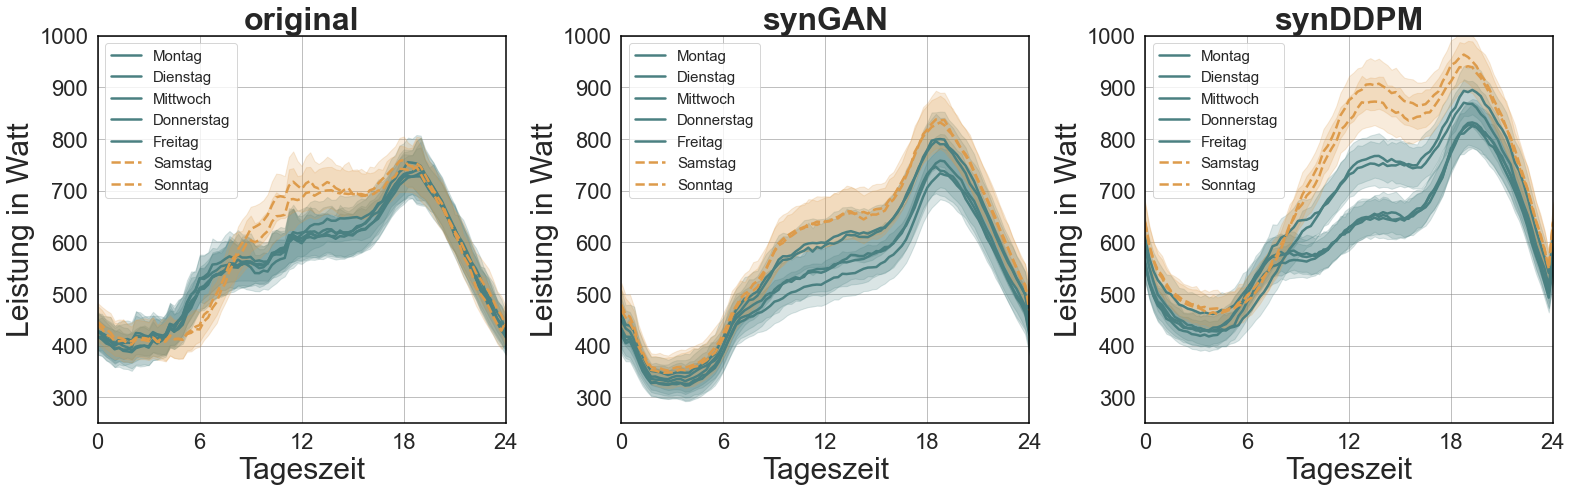

In [169]:
# Create a 1x3 grid for subplots
fig, axs = plt.subplots(1, 3, figsize=(22, 7))

# Specify linestyle for each weekday
linestyle_dict = {'Montag': '-', 'Dienstag': '-', 'Mittwoch': '-', 'Donnerstag': '-', 'Freitag': '-',
                  'Samstag': '--', 'Sonntag': '--'}

# Plot for concatenated_df_privat_mean
plot_dataframe(axs[0], original_whm_means_ci2, linestyle_dict, 'original', fontsize=24, ylim=(250,1000))

# Plot for concatenated_df_oeff_mean
plot_dataframe(axs[1], syngan_whm_means_ci2, linestyle_dict, 'synGAN', fontsize=24, ylim=(250,1000))

# Plot for concatenated_df_gew_mean
plot_dataframe(axs[2], synddpm_whm_means_ci2, linestyle_dict, 'synDDPM', fontsize=24, ylim=(250,1000))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

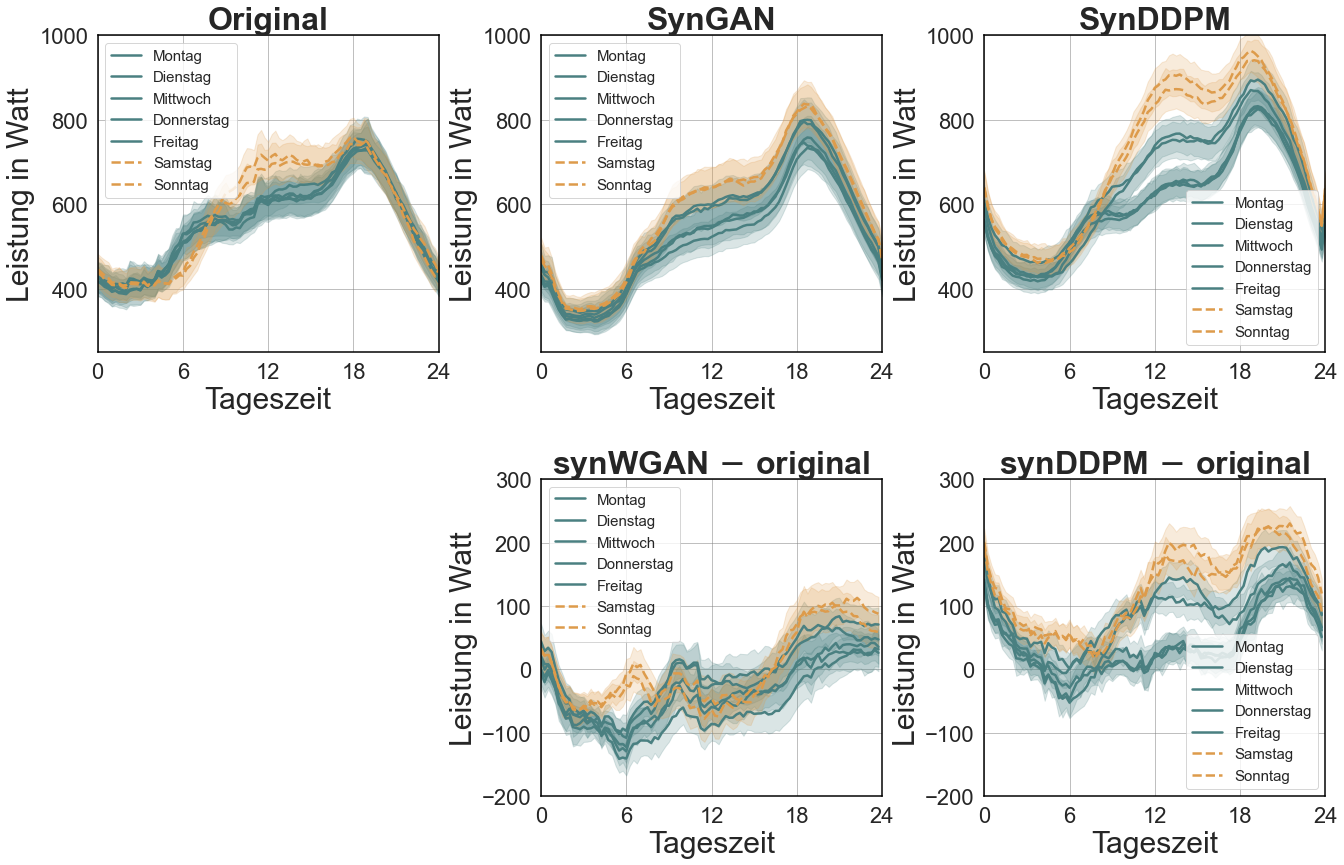

In [170]:
import matplotlib.gridspec as gridspec

# Create a 2x3 grid for subplots with a spacer for 'a' in the second row
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(22, 14), gridspec_kw={'height_ratios': [1, 1]})

# Remove the spines and ticks for the empty subplot
axs[1, 0].axis('off')

# Specify linestyle for each weekday
linestyle_dict = {'Montag': '-', 'Dienstag': '-', 'Mittwoch': '-', 'Donnerstag': '-', 'Freitag': '-',
                  'Samstag': '--', 'Sonntag': '--'}

# Plot for original_whm_means_ci2
plot_dataframe(axs[0, 0], original_whm_means_ci2, linestyle_dict, 'Original', fontsize=24, ylim=(250, 1000))

# Plot for syngan_whm_means_ci2
plot_dataframe(axs[0, 1], syngan_whm_means_ci2, linestyle_dict, 'SynGAN', fontsize=24, ylim=(250, 1000))

# Plot for synddpm_whm_means_ci2
plot_dataframe(axs[0, 2], synddpm_whm_means_ci2, linestyle_dict, 'SynDDPM', fontsize=24, ylim=(250, 1000))


plot_dataframe(axs[1, 1], ori_gan_diff_whm_means, linestyle_dict, 'synWGAN $\! - \!$ original',fontsize=24, ylim=(-200, 300))

plot_dataframe(axs[1, 2], ori_ddpm_diff_whm_means, linestyle_dict, 'synDDPM $\! - \!$ original',fontsize=24, ylim=(-200, 300))

# Adjust layout and show the plot
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()
